# Transformer M - Data Cartography

#### Required Files

* Transformer-M's predictions and latents: [this repo](https://drive.google.com/drive/folders/1q_sVl_a5_Aw1xkldp6D-H2aCjcgd5xVq)
* Stats file: [`results.pkl.gz`](https://drive.google.com/file/d/1alzEuMZ-Xke86v9rMolnBx4NOyX-2_Cz/view?usp=sharing)
* `split_dict.pt` from dataset
* `raw/data.csv.gz` from dataset
* KPGT fingerprint/descriptor memmaps: [this repo](https://drive.google.com/drive/folders/1NrS7of9uqjwOQf09m7msiTaCsKSJ0ni2?usp=sharing)

## Observations:
* Might not be bad to exclude these two homo-lumogap outliers (Only [He] in smiles) with ~46 gaps :/
* In plot of num_edges vs error, on num edges around 20, it seems the outliers are all long-chains of C and O (longer than the C-chains in the rest) no? (plot with `fig.show()` and hover over points to see smiles)

In [1]:
tm_preds_folder = '/data/pcqm4mv2_datahub/diagnosis/pcqm-0.07938-dump'
smiles_df_filepath = '/data/pcqm4mv2_datahub/datasets/2d/pcqm4m-v2/raw/data.csv.gz'
split_filepath = '/data/pcqm4mv2_datahub/datasets/2d/pcqm4m-v2/split_dict.pt'
fingerprint_memmap_filepath='/data/pcqm4mv2_datahub/kpgt_fingerprint_and_descriptor/fingerprint.np'
descriptor_memmap_filepath='/data/pcqm4mv2_datahub/kpgt_fingerprint_and_descriptor/descriptor.np'

In [2]:
import os
root_dir = tm_preds_folder
os.listdir(root_dir)

['latent_reps_train.npy',
 'preds_val.npy',
 'preds_train.npy',
 'latent_reps_val.npy']

In [3]:
import os
import sys
sys.path.insert(0, '/home/shayan/phoenix/graphite/')
import torch
import torch.nn
from sklearn.decomposition import PCA
import pandas
import numpy
import plotly_express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gzip
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
import rdkit
import rdkit.Chem
from rdkit.Chem import Descriptors
from graphite.contrib.kpgt.data.descriptors.rdDescriptors import RDKIT_PROPS
from sklearn.feature_selection import r_regression
import seaborn as sns
rdkit_dc_featnames = RDKIT_PROPS["1.0.0"]

In [4]:
df_smiles = pandas.read_csv(smiles_df_filepath)
df_smiles = df_smiles.set_index('idx')
split_idx = torch.load(split_filepath)
df_splits = []

for k, v in split_idx.items():
    tmp = pandas.DataFrame(dict(item_id=v))
    tmp['split'] = k
    df_splits.append(tmp)
    
df_splits = pandas.concat(df_splits)
with gzip.open('results.pkl.gz', 'rb') as handle:
    data_props = pickle.load(handle)
    df_props = data_props['df_item_properties']
    df_props['gap'] = df_smiles.homolumogap.to_numpy()
    df_props['smiles'] = df_smiles.smiles.to_list()
    df_props['shortest_path_std'] = df_props['shortest_path_std'].apply(lambda x: x.item())
    df_props['shortest_path_mean'] = df_props['shortest_path_mean'].apply(lambda x: x.item())
    df_props['item_id'] = numpy.arange(df_props.shape[0])
    df_props = pandas.merge(df_props, df_splits, on=['item_id'], how='outer')
    
    
# - parsing predicted homolumugaps
preds_df = []

preds = numpy.load(os.path.join(root_dir, 'preds_val.npy'))[:split_idx['valid'].shape[0], 0]
print(split_idx['valid'].shape)
tmp_df = pandas.DataFrame(dict(
    pred=preds.ravel(),
    item_id=split_idx['valid']
))

preds_df.append(tmp_df)

preds = numpy.load(os.path.join(root_dir, 'preds_train.npy'))[:split_idx['train'].shape[0], 0]
print(split_idx['train'].shape)
tmp_df = pandas.DataFrame(dict(
    pred=preds.ravel(),
    item_id=split_idx['train']
))

preds_df.append(tmp_df)

preds_df = pandas.concat(preds_df)
df_props = pandas.merge(df_props, preds_df, on=['item_id'], how='outer')
df_props['error'] = df_props['gap'] - df_props['pred']
df_props['error_abs'] = df_props['error'].abs()

fingerprint_memmap = np.memmap(
    fingerprint_memmap_filepath,
    dtype='float32',
    mode='r',
    shape=(3746620, 512)
)

descriptor_memmap = np.memmap(
    descriptor_memmap_filepath,
    dtype='float32',
    mode='r',
    shape=(3746620, 201)
)

(73545,)
(3378606,)


In [5]:
df_props.head()

,shortest_path_mean,shortest_path_std,shortest_path_median,num_nodes,num_edges,gap,smiles,item_id,split,pred,error,error_abs
0,3.672840,2.269273,3.0,18,40,3.047675,O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C,0,train,3.086446,-0.038771,0.038771
1,3.930796,2.454174,4.0,17,34,4.410966,COc1cc(OC)ccc1/C=C/N(C(=O)C)C,1,train,4.444311,-0.033345,0.033345
2,3.765625,2.297430,3.5,16,32,4.639541,C=CCN(C(=O)C)/C=C/c1ccccc1C,2,train,4.649483,-0.009942,0.009942
3,3.765625,2.297430,3.5,16,32,4.492600,C=CCN(C(=O)C)/C=C/c1ccccc1F,3,train,4.484864,0.007735,0.007735
4,3.765625,2.297430,3.5,16,32,4.612330,C=CCN(C(=O)C)/C=C/c1ccccc1Cl,4,train,4.610106,0.002223,0.002223


## Q: Absolute-error and graph properties - data cartography

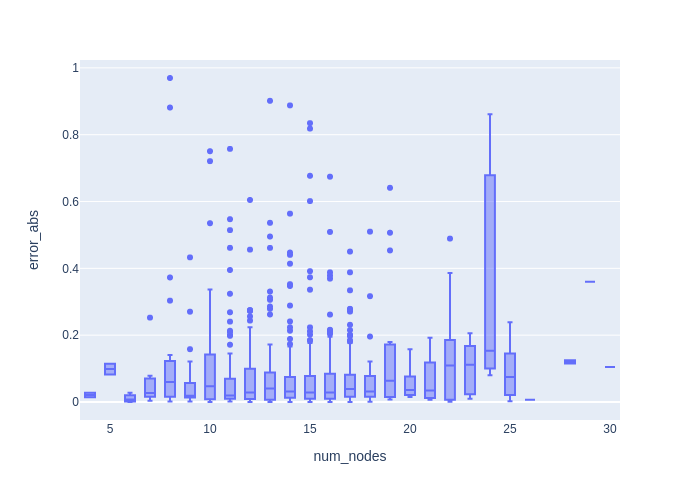

In [6]:
fig = px.box(
    df_props[df_props.split=='valid'].sample(1000),
    x='num_nodes',
    y='error_abs',
)
fig.show('png')

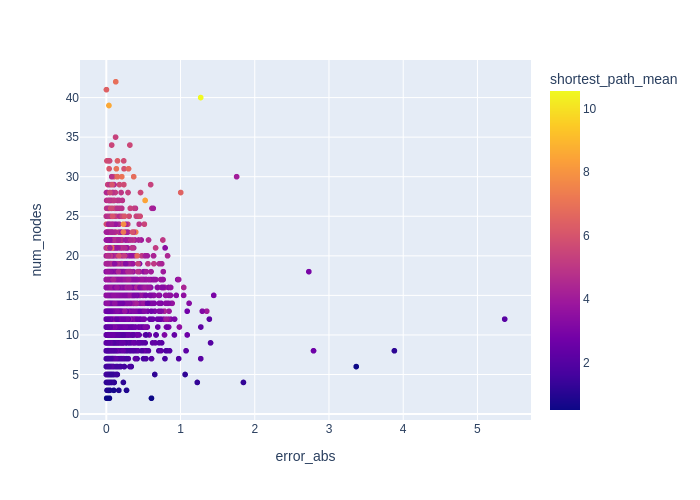

In [7]:
fig = px.scatter(
    df_props[df_props.split=='valid'].sample(10000),
    x='error_abs',
    y='num_nodes',
    color='shortest_path_mean',
    hover_data=['num_nodes', 'num_edges', 'gap', 'error_abs', 'pred', 'item_id', 'smiles']
)
fig.show('png')

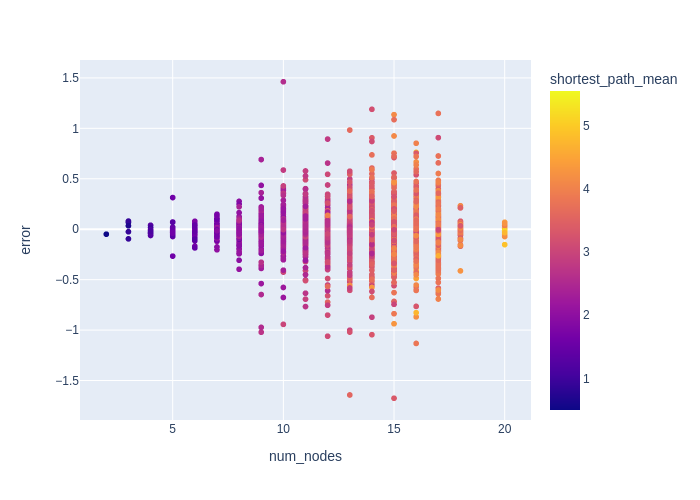

In [8]:
fig = px.scatter(
    df_props[df_props.split=='train'].sample(10000),
    x='num_nodes',
    y='error',
    color='shortest_path_mean',
    hover_data=['num_nodes', 'num_edges', 'gap', 'error_abs', 'pred', 'item_id']
)
fig.show('png')

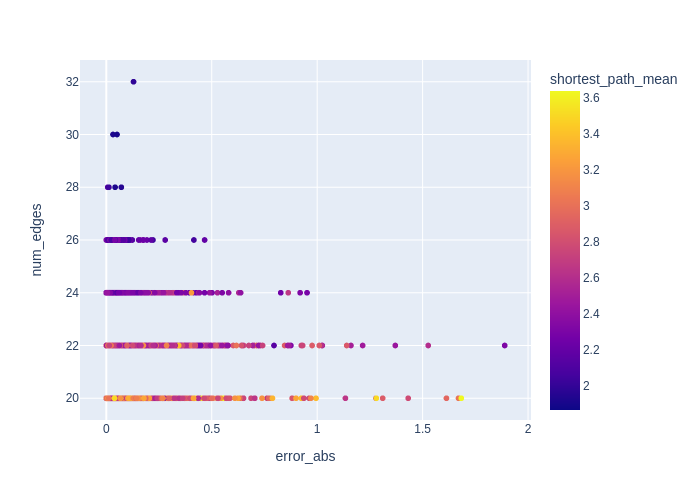

In [9]:
fig = px.scatter(
    df_props[(df_props.split=='train') & (df_props.num_nodes==11)].sample(10000),
    x='error_abs',
    y='num_edges',
    color='shortest_path_mean',
    hover_data=['num_nodes', 'num_edges', 'gap', 'error_abs', 'pred', 'item_id', 'smiles']
)
fig.show('png')

## Q: Highest mismatches in train and val: is there anything noticeable?

In [10]:
df_props[(df_props.split=='train')].sort_values(by=['error_abs'], ascending=False).head()

,shortest_path_mean,shortest_path_std,shortest_path_median,num_nodes,num_edges,gap,smiles,item_id,split,pred,error,error_abs
2880108,0.000000,0.000000,0.0,2,0,47.023995,[He].[He],2880108,train,14.002277,33.021717,33.021717
2912974,0.000000,0.000000,0.0,3,0,46.381806,[He].[He].[He],2912974,train,14.049695,32.332111,32.332111
2729463,0.000000,0.000000,0.0,3,0,21.831694,[Ar].[Ar].[Ar],2729463,train,14.046888,7.784806,7.784806
422049,3.182222,1.774734,3.0,15,30,11.559396,CN(/C=C(\c1ccccc1C)/C(=O)O)C,422049,train,5.156818,6.402578,6.402578
1591957,3.697778,2.378708,3.0,15,30,12.239681,CC/N=C(\CNc1cc(N)cc(c1)F)/O,1591957,train,5.851661,6.388020,6.388020


In [11]:
df_props[(df_props.split=='valid')].sort_values(by=['error_abs'], ascending=False).head() #.error_abs.describe()

,shortest_path_mean,shortest_path_std,shortest_path_median,num_nodes,num_edges,gap,smiles,item_id,split,pred,error,error_abs
3722577,0.000000,NaN,0.0,1,0,15.934987,[Kr],3722577,valid,7.624990,8.309998,8.309998
3715513,1.125000,0.806226,1.0,4,6,8.255934,F[Ga](F)F,3715513,valid,13.965564,-5.709630,5.709630
3694439,2.083333,1.080663,2.0,12,30,6.843663,C1[N@@]2[CH][C@H]3[C@@H](C2)[C@H]2C[N@@]1[CH][...,3694439,valid,1.476372,5.367291,5.367291
3430326,1.600000,1.224745,1.0,5,8,3.820478,[CH]CCCC,3430326,valid,7.820246,-3.999767,3.999767
3585750,1.125000,0.793116,1.0,8,12,2.329295,F[C](F)F.F[S](F)F,3585750,valid,6.210439,-3.881144,3.881144


## Q: Any relationship between descriptors and high-error elements in valid?

In [53]:
from sklearn.feature_selection import mutual_info_regression

In [56]:
%%time
split='valid'
fp = numpy.array(fingerprint_memmap[split_idx[split], :])
dc = numpy.array(descriptor_memmap[split_idx[split], :])

mireg_error_abs = mutual_info_regression(y=df_props[(df_props.split==split)].error_abs.to_numpy(), X=numpy.nan_to_num(dc[:, 1:]))

pearson_r = r_regression(numpy.nan_to_num(dc[:, 1:], 0), df_props[(df_props.split==split)].error.to_numpy())
pearson_r_error_abs = r_regression(numpy.nan_to_num(dc[:, 1:], 0), df_props[(df_props.split==split)].error_abs.to_numpy())

/home/shayan/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:306: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


CPU times: user 1min 17s, sys: 3.66 s, total: 1min 21s
Wall time: 1min 15s


/home/shayan/anaconda3/envs/gnn/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:306: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


In [60]:
mireg_error_abs.max()

0.047422805185172834

In [58]:
df_dc_nmi_valid = pandas.DataFrame(dict(
    descriptor=rdkit_dc_featnames,
    mireg_error_abs=mireg_error_abs.ravel(),
    pearson_r_error=pearson_r,
    pearson_r_error_abs=pearson_r_error_abs
))

In [61]:
df_dc_nmi_valid.sort_values(by=['mireg_error_abs'], ascending=False).head()

,descriptor,mireg_error_abs,pearson_r_error,pearson_r_error_abs
95,SlogP_VSA2,0.047423,-0.039959,0.209559
99,SlogP_VSA6,0.045957,0.012268,-0.084004
88,SMR_VSA7,0.044668,0.008048,-0.081315
29,FractionCSP3,0.036519,-0.045911,0.159453
56,NumAromaticRings,0.032385,0.009258,-0.120527


In [63]:
df_dc_nmi_valid.sort_values(by=['pearson_r_error_abs'], ascending=False).head()

,descriptor,mireg_error_abs,pearson_r_error,pearson_r_error_abs
95,SlogP_VSA2,0.047423,-0.039959,0.209559
29,FractionCSP3,0.036519,-0.045911,0.159453
66,PEOE_VSA1,0.030285,-0.012592,0.134366
81,SMR_VSA1,0.029921,0.000374,0.127132
34,Kappa1,0.021618,-0.037204,0.126303


In [48]:
df_dc_nmi_valid.sort_values(by=['pearson_r_error'], ascending=True).head()

,descriptor,pearson_r_error,pearson_r_error_abs
184,fr_piperzine,-0.060471,0.062962
170,fr_morpholine,-0.053907,0.047392
6,Chi1n,-0.046539,0.082182
29,FractionCSP3,-0.045911,0.159453
87,SMR_VSA6,-0.045551,0.100191


## Q: Any major distribution difference for descriptors in `general` vs `high-abs-error` groups?

Check the [descriptor_dists](https://github.com/shayanfazeli/graphite_pcqm4mv2/tree/master/lab/notebooks/diagnosing_error/transformer_m/descriptor_distrs) folder for distribution plots computed per below:

In [ ]:
%%time
split='valid'
fp = numpy.array(fingerprint_memmap[split_idx[split], :])
dc = numpy.array(descriptor_memmap[split_idx[split], :])

tmp_df = pandas.DataFrame(dict(
        gap=df_props[(df_props.split==split)].error.to_numpy(),
        error=df_props[(df_props.split==split)].error.to_numpy(),
        error_abs=df_props[(df_props.split==split)].error_abs.to_numpy()))

for i, k in enumerate(rdkit_dc_featnames):
    tmp_df[k] = dc[:, i+1]
    
tmp_df = tmp_df.sort_values(by=['error_abs'], ascending=False)

In [ ]:
q = 0.9

for feat in tqdm(rdkit_dc_featnames):
    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    sns.distplot(tmp_df[feat])
    plt.grid()
    plt.title('overall dist')
    plt.subplot(1,2,2)
    plt.title('high-loss dist')
    plt.grid()
    sns.distplot(tmp_df[tmp_df.error_abs > tmp_df.error_abs.quantile(q)][feat])

    plt.savefig(f'dists/{feat}.png', dpi=100)